In [1]:
import os.path
from os import path
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
print('Python works!')

Python works!


In [3]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2019-06-12 12:37:10--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.66.52.154
Connecting to download.microsoft.com (download.microsoft.com)|23.66.52.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  6.23MB/s    in 3m 23s  

2019-06-12 12:40:34 (3.87 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [5]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [11]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [7]:
#Dense implements the operation:
#output = activation(dot(input, kernel) + bias)
#Units are the dimensionality of the output space for the layer,
#which equals the number of hidden units
#Activation and loss functions may be specified by strings or classes

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#The compile method configures the model’s learning process
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


Instructions for updating:
Colocations handled automatically by placer.


In [8]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [10]:
# Note that this may take some time.
#The fit method does the training in batches
# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.

history = model.fit_generator(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=validation_generator)

model.save("/tmp/cats-v-dogs/cats_dogs_model.h5")

Epoch 1/10
  3/225 [..............................] - ETA: 10:07 - loss: 0.6148 - acc: 0.6633

/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


140/225 [=================>............] - ETA: 3:31 - loss: 0.5818 - acc: 0.7019

/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expect

187/225 [=======================>......] - ETA: 1:34 - loss: 0.5723 - acc: 0.7088

/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

225/225 [==============================] - 580s 3s/step - loss: 0.5624 - acc: 0.7142 - val_loss: 0.4941 - val_acc: 0.7687
Epoch 2/10
225/225 [==============================] - 572s 3s/step - loss: 0.4805 - acc: 0.7680 - val_loss: 0.4512 - val_acc: 0.7915
Epoch 3/10
225/225 [==============================] - 572s 3s/step - loss: 0.4287 - acc: 0.8033 - val_loss: 0.4495 - val_acc: 0.7907
Epoch 4/10
225/225 [==============================] - 2568s 11s/step - loss: 0.3748 - acc: 0.8313 - val_loss: 0.5137 - val_acc: 0.7743
Epoch 5/10
225/225 [==============================] - 602s 3s/step - loss: 0.3187 - acc: 0.8637 - val_loss: 0.5576 - val_acc: 0.7695
Epoch 6/10
225/225 [==============================] - 601s 3s/step - loss: 0.2529 - acc: 0.8958 - val_loss: 0.5143 - val_acc: 0.8123
Epoch 7/10
225/225 [==============================] - 597s 3s/step - loss: 0.1875 - acc: 0.9258 - val_loss: 0.5468 - val_acc: 0.8063
Epoch 8/10
225/225 [==============================] - 646s 3s/step - loss: 0.1

<Figure size 432x288 with 0 Axes>

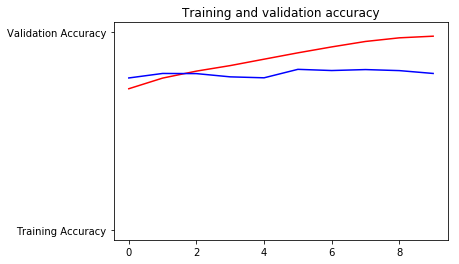

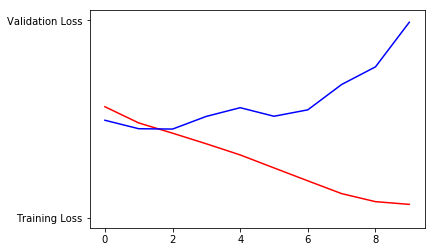

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
   
  #The predict method applies the trained model to inputs
  #to generate outputs
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")